# What can we learn from twitter data? 

## Disclaimer
As we are working with uncensored tweets captured indiscriminately from Calgary, there is a possibility that this notebook may display content that is offensive or vulgar. These tweets do not represent the views of Cybera or its employees. This dataset is simply meant to be an activity in working with text-based data, and some possible analysis surrounding it.  

## Twitter Data

By now we have developed a familiarity with our Twitter data. At this point, we might be wondering what kind of questions we can answer or insights we can gain from this data. An exciting first choice is to ask ourselves something that we may all think of as familiar: how are we feeling today? But rather than asking _ourselves_ that question, we will extract that data from our Twitter data set. This is known as **Sentiment Analysis**.


Notice periodic behaviour

TODO: Clean plot/visualize it differently to show when the most popular tweeting hours/days are. Topic/Sentiment analysis on those days??? 

## Importing the Data

As we've done before, we are going to import our data and adjust the time stamp. This time however, we are going to try and understand _when_ people are tweeting within Calgary .

In [309]:
import pandas as pd
import urllib.request
import ast
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

target_url="https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/geeky-summit/tweets_cleaned.csv"
file_name="tweets_cleaned.csv"
urllib.request.urlretrieve(target_url, file_name)

df = pd.read_csv(file_name,parse_dates=['created_at_date']) 
# Convert to mountain standard time 
df.created_at_date= df.created_at_date.dt.tz_localize('UTC').dt.tz_convert('MST')



## Sentiment Analysis

Sentiment analysis easy for a human to do. It's quite simple to distinguish a sentence that is positive, negative, or neutral simply by reading it. Of course, how do we get a computer to do it for us? There are in fact several ways to do this such as training a neural network to classify our data. Unfortunately, we don't have that luxury! Luckily however, there are also libraries that assign a score, positive or negative, to certain words and characters. These libraries are called **lexicons** and each lexicon will score an individual word as positive or negative, and words that aren't within the lexicon will have a score of zero. 

### VADER

The lexicon we will be using is called VADER (Valence Aware Dictionary and sEntiment Reasoner), and you can read more about it [here](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf) and [here](https://github.com/cjhutto/vaderSentiment). However, for us VADER is the "most ideal" sentiment lexicon as it also encodes sentiment for emojis and different levels of capitalization: something that we'll likely see a lot of on Twitter. Let's take a look at what VADER does below 

In [166]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

sentence = "I love eating pasta" 

print(analyser.polarity_scores(sentence))

{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.6369}


Where VADER returns a score for negative language `neg`, a score for neutral language `neu`, a score for positive language `pos`, and a summary score `compound`. Where in this case we see that the sentence `I love eating pasta` is predominantly positive in nature. 

One of the nice things about VADER is that it will also assume that text in capitals is either more positive or negative. For example, if we "LOVE pasta", it is more positive that in we simply "love pasta", as seen below. 

In [178]:
sentence = "I LOVE eating pasta" 

print(analyser.polarity_scores(sentence))

{'neg': 0.0, 'neu': 0.288, 'pos': 0.712, 'compound': 0.7125}


And if we add emojis to this, those emojis are also scored!

In [169]:
sentence = "I LOVE eating pasta :)" 

print(analyser.polarity_scores(sentence))

{'neg': 0.0, 'neu': 0.201, 'pos': 0.799, 'compound': 0.8374}


As well, negative sentiments behave as you'd expect 

In [172]:
print(analyser.polarity_scores("I hate pasta"))
print(analyser.polarity_scores("I HATE pasta"))
print(analyser.polarity_scores("I HATE pasta >:("))
     

{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}
{'neg': 0.816, 'neu': 0.184, 'pos': 0.0, 'compound': -0.6633}
{'neg': 0.891, 'neu': 0.109, 'pos': 0.0, 'compound': -0.8455}


However, we should be aware that VADER will not recognize positive or negative words as they may appear on twitter:

In [179]:
print(analyser.polarity_scores("I LOVE pasta"))
print(analyser.polarity_scores("I #LOVE pasta"))

{'neg': 0.0, 'neu': 0.169, 'pos': 0.831, 'compound': 0.7125}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


Hence the importance of cleaning your data! That said, as hashtags can also be misleading in terms of what appears at the end of tweets, we will focus our analysis on _only_ the text bodies; we will ignore all hashtags and `@` user mentions. 

### When are people Tweeting in Calgary

Before we begin our sentiment analysis, it is always a good idea to understand _when_ people are tweeting as time can be an important factor in sentiment analysis (for example, before lunch or dinner one might see some "hanger" effects in the tweets!). In this case, let's take a quick look at the time distribution histogram of tweets. 

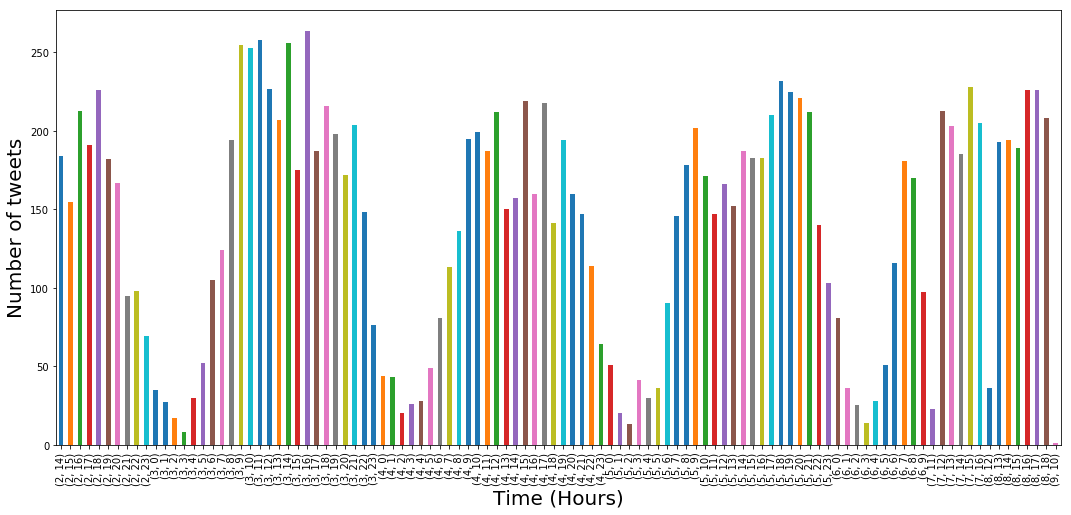

In [312]:
ax = df['created_at_date'].groupby([
            df.created_at_date.dt.day, 
            df.created_at_date.dt.hour
    ]).count().plot(kind="bar",
                    figsize = (18,8))

ax.set_xlabel("Time (Hours)", size = 20)
ax.set_ylabel("Number of tweets", size=20)
plt.show()

Unsurprisingly, we see that there is a periodic behavior in terms of when tweets are... tweeted. In this case we see a daily lull starting from around 22:00 until 6:00, or the times when people are typically sleeping and not thinking about writing tweets. 

### Scoring the Sentiment of Twitter Data

Now that we have a basic understanding of how VADER works, calculating the sentiment of all our tweets is quite straightforward. In our case, we are only interested in the compound sentiment of the tweets. 

In [314]:
def compoundSentiment(row):
    # Notice here how we're calling explicitly the extended_tweet_cleaned
    # entry 
    score = analyser.polarity_scores(row.extended_tweet_cleaned)
    return score['compound']

# Here we use the 'apply' function to apply a function to our data frame
# axis=1 means to apply this function row-by-row

df['score'] = df.apply(compoundSentiment, axis=1)

df.head()

,created_at_date,hashtags_string,user_string,user_location,lang,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned,score
0,2018-11-02 14:01:56-07:00,,Symin16,Toronto ✈ Calgary,en,NaN,NaN,♠,jessmayumba85,@Symin16 I’d like to know who,I’d like to know who,0.3612
1,2018-11-02 14:02:01-07:00,,TwoCanSamAdams,YYC,en,NaN,NaN,hannahrae cuddleslug,thimblewad,@TwoCanSamAdams Legit. There are still chunks ...,Legit. There are still chunks in the sink an...,-0.2263
2,2018-11-02 14:02:05-07:00,job Calgary SupplyChain Hiring CareerArc,,Calgary,en,51.004583,-114.007914,TMJ - CAL Manuf Jobs,tmj_cal_manuf,Can you recommend anyone for this #job in #Cal...,"Can you recommend anyone for this in , AB? ...",0.3612
3,2018-11-02 14:02:10-07:00,,,🌎📱,en,NaN,NaN,Sunny Rai,TheSunsRay,Kids See Ghosts: love this track,Kids See Ghosts: love this track,0.6369
4,2018-11-02 14:02:13-07:00,Calgary job,,Calgary,en,50.997882,-114.074005,TMJ-CAL Retail Jobs,tmj_cal_retail,"See our latest #Calgary, AB #job and click to ...","See our latest , AB and click to apply: bar...",0.0000


Where we'll notice on the far left of our data frame, we now have a column called `score` with all our sentiment scores from the text. One important thing to note is that if a tweet does not have a word contained with in the lexicon for scoring, the sentiment score is zero. 

### Sentiment as a function of time

A natural first question with this data to ask is "Does how positively or negatively people are talking change throughout the day?". This could be a interesting question for a few reasons, the most predominant being is that it could be used to detect current events. If there is suddenly an influx of very positive or very negative tweets, that could indicate that there is an important event happening. Let's see how the sentiment of tweets changes per-hour in this data set. In order to do that, we have to group our data by time first, and then create a boxplot so that we may get some indication of how the data is distributed. 

### Brief note on box plots

Boxplots are an excellent way to summarize statistical data as they readily display how the data is distributed - giving you a better idea as to the range, and more importantly, the distinguishability of your data. However if you've never seen one before, here's a few important things to note about boxplots and what everything they display means. To begin, here is a labeled boxplot

![alt-text](https://cdn-images-1.medium.com/max/800/1*2c21SkzJMf3frPXPAR_gZA.png)

What we see here is a few important pieces 
1. The 'box' itself is centered on the median of the data, and has width equal to the interquartile range, or in discrete data this box contains 50% of all points. 
2. The lines that extend out are known as "whiskers" and extend from the bottom of the box, to a distance equal to 1.5 times the width of the box on each side (the inter quartile range)
3. Finally, any points outside of the whiskers are drawn individually 

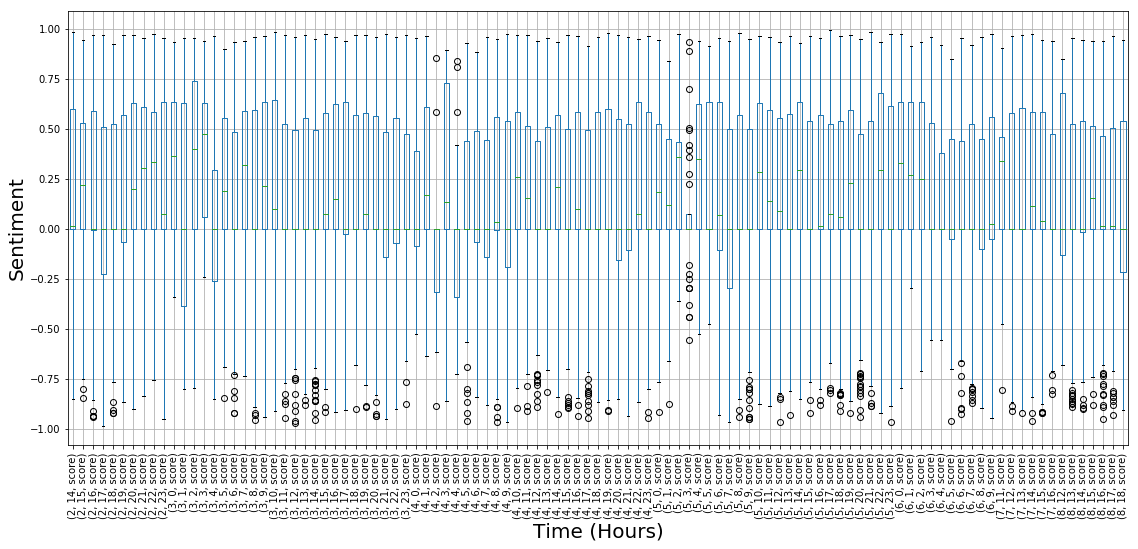

In [318]:
s_df = df.drop_duplicates(subset='extended_tweet_cleaned', keep="last").copy()
# s_df = s_df[s_df.score !=0]
s_df = s_df[s_df.created_at_date.dt.day !=9]


median = s_df[['score', 
             'created_at_date']].groupby(
                            by=[
                                s_df.created_at_date.dt.day, 
                                s_df.created_at_date.dt.hour])

ax = median.boxplot(subplots=False,
                             figsize = (19,8),
                             rot = 90,
                            )

ax.set_xlabel("Time (Hours)", size = 20)
ax.set_ylabel("Sentiment", size = 20)
plt.show()

Where in the plot above, we don't see a lot of variation. That's not very exciting. However, there is a reason for that! But... 

### Exercise 

There is a way to see some more variation! Add a single line of code to the cell above to filter out some data so that we can actually see that variation.

**Hint** Remember that if there are no words in the VADER lexicon within a tweet, it returns a sentiment score in `s_df['score']` as zero. 


### Distinguishability of data 

Once you've filtered the tweets down appropriately to see some minor variations within the data, you may notice what look like interesting variations in the size of the boxes! Unfortunately however, we also have to keep in mind our _time distribution_ that we created earlier. In almost all cases, our significantly different sentiment takes place during times where we have scored significantly fewer tweets - our results are biased due to a lack of data. 

Not to worry however! This is not unexpected. As we've aggregated about 14000 tweets from Calgary over a few days, we're simply seeing aggregate scores about how people are writing about numerous topics every day. Which brings us to an interesting question: Can we isolate those topics, and how to people feel about them? 

## Topic Analysis 

Topic analysis is an exciting technique that allows you to cluster documents/sentences or in our case, tweets, into groups of text around a similar topic as well as calculate key words in that topic. There are numerous algorithms and methods  for this task, however what we'll focus on is Latent Dirichlet Allocation (LDA).

### LDA: The Basics

At a high level, at a high level what LDA does is it converts words/documents into a linear algebra and statistics problem, and then uses this conversion to cluster your documents, where each cluster represents a topic.  To understand this at a high level, we must first go through a few definitions

### Definitions

##### Corpus
A corpus refers to all the unique words contained in your text. In our case, this corpus consists of all the words within our tweets. 

##### Word Vectors

A word vector is the conversion of a word into a sparse 'one-hot' vector. What this means is that each word contained within all your texts is mapped to a unique vector. For example, the word "karate" may appear as 

\begin{equation}
\mbox{Karate} = 
\begin{pmatrix}
0 \\
\vdots \\
1 \\
\vdots \\
0
\end{pmatrix}
\end{equation}

Where it is represented as a _unique_ and _sparse_ vector that contains a single non-zero entry. The size of each word vector is the same, and is the size of our corpus. 

##### Document Vectors

A document vector is simply the word vector representation of a document/sentence or in our case, a tweet. For example, the sentence
``` 
wax on, wax off
```

is simply the vector sum of our word vectors for each word
\begin{equation}
\vec{D}_1 = \vec{w}_1 + \vec{w}_2 + \vec{w}_1 + \vec{w_3}
\end{equation}


##### Corpus (round two) 

Now that we've defined word and document vectors, our corpus is defined as our entire set of documents, or

\begin{equation}
C = \{\vec{D}_1, \vec{D}_2, ..., \vec{D}_N\}
\end{equation} 
where $N$ is the total number of documents, in our case the total number of tweets. 

In [316]:
subset = df[df.created_at_date.dt.day ==3]
print(len(subset))
subset = subset[subset.screen_name != '311calgary'] #verhy formal reporting account, avoid those topics 
print(len(subset))
subset = subset.drop_duplicates(subset='extended_tweet_cleaned')
subset

3688
3592


,created_at_date,hashtags_string,user_string,user_location,lang,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned,score
1580,2018-11-03 00:00:10-07:00,,LFCTransferRoom,Canada,en,NaN,NaN,Captain Fantastic8,nattyroons,@LFCTransferRoom So what was Shaqiri's time🤔,So what was Shaqiri's time🤔,0.0000
1581,2018-11-03 00:01:18-07:00,ableg,realmarkwells,Calgary,en,NaN,NaN,Jeff Callaway,JeffCallaway,@realmarkwells NDP posturing #ableg,NDP posturing,0.0000
1582,2018-11-03 00:02:26-07:00,,GoaleeMurph kasim_a29 GalvanisdHockey,"Calgary, AB, Canada",en,NaN,NaN,FHumpires.com,fhumpires,@GoaleeMurph @kasim_a29 @GalvanisdHockey Glad ...,Glad I specified which keeper then witho...,0.4588
1583,2018-11-03 00:02:51-07:00,,,Calgary Alberta Canada,en,51.045000,-114.057000,Jennifer Park,naturaliconyyc,Sun worship💜💜💜. November is upon us. Not my fa...,Sun worship💜💜💜. November is upon us. Not my fa...,-0.3412
1584,2018-11-03 00:05:13-07:00,ATPZORRO LOVEYYC,ATPlive,"Calgary, AB",en,NaN,NaN,Alex Wihak,WihakAlex,@ATPlive I know it’s not a meme but how I feel...,I know it’s not a meme but how I feel someti...,0.0000
1585,2018-11-03 00:06:07-07:00,,,NaN,en,NaN,NaN,Pikachu THEATHEIST,AnomAtheist17,This video by Creationist Cat is fucking aweso...,This video by Creationist Cat is fucking aweso...,0.7346
1586,2018-11-03 00:07:33-07:00,,CarrieCnh12 andrewphung KimsConvenience bitter...,Calgary,en,NaN,NaN,Julie Van Rosendaal,dinnerwithjulie,@CarrieCnh12 @andrewphung @KimsConvenience @bi...,❤️he’s just the best!,0.6696
1587,2018-11-03 00:09:00-07:00,,LeroyEdwards8 Henry14Kay jasperlfc marcialynnj...,Canada,en,NaN,NaN,Captain Fantastic8,nattyroons,@LeroyEdwards8 @Henry14Kay @jasperlfc @marcial...,Thanks Ler...,0.7213
1588,2018-11-03 00:12:05-07:00,,,Canada,en,NaN,NaN,Captain Fantastic8,nattyroons,What time is our game today..My LFC Family😎,What time is our game today..My LFC Family😎,0.0000
1589,2018-11-03 00:13:28-07:00,,MMFlint,"British Columbia, Canada",en,NaN,NaN,RJ Spear,spearitofgf,"@MMFlint Sorry Michael, but there were four me...","Sorry Michael, but there were four medical s...",0.9009


# TODO: Sentiment of a topic? 

In [6]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk

In [7]:
def sent_to_words(row):
    sentence = row.extended_tweet_cleaned
    return(gensim.utils.simple_preprocess(sentence,min_len=3))  

subset['tokens'] = subset.apply(sent_to_words, axis=1)
subset['tokens']
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

nltk.download('wordnet')
from nltk.corpus import wordnet as wn

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alextennant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alextennant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
stop_words.append('amp')
stop_words = set(stop_words)


In [9]:
def tokens_to_lda(row):
    data_token = row.tokens
    tokens = [token for token in data_token if token not in stop_words]
    tokens = [get_lemma(token) for token in tokens]
    return tokens
    
subset['lemma'] = subset.apply(tokens_to_lda, axis=1)

subset = subset[subset['lemma'].apply(lambda x: len(x) > 3)]
from gensim import corpora

dictionary = corpora.Dictionary(subset['lemma'])
corpus = [dictionary.doc2bow(text) for text in subset['lemma']]

In [10]:
subset[subset['lemma'].apply(lambda x: len(x) > 4)]

,created_at_date,hashtags_string,user_string,user_location,lang,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned,score,tokens,lemma
1582,2018-11-03 00:02:26-07:00,,GoaleeMurph kasim_a29 GalvanisdHockey,"Calgary, AB, Canada",en,NaN,NaN,FHumpires.com,fhumpires,@GoaleeMurph @kasim_a29 @GalvanisdHockey Glad ...,Glad I specified which keeper then witho...,0.4588,"[glad, specified, which, keeper, then, without...","[glad, specify, keeper, without, reference, di..."
1583,2018-11-03 00:02:51-07:00,,,Calgary Alberta Canada,en,51.045000,-114.057000,Jennifer Park,naturaliconyyc,Sun worship💜💜💜. November is upon us. Not my fa...,Sun worship💜💜💜. November is upon us. Not my fa...,-0.3412,"[sun, worship, november, upon, not, fave, mont...","[sun, worship, november, upon, fave, month, sc..."
1584,2018-11-03 00:05:13-07:00,ATPZORRO LOVEYYC,ATPlive,"Calgary, AB",en,NaN,NaN,Alex Wihak,WihakAlex,@ATPlive I know it’s not a meme but how I feel...,I know it’s not a meme but how I feel someti...,0.0000,"[know, not, meme, but, how, feel, sometimes, f...","[know, meme, feel, sometimes, father]"
1585,2018-11-03 00:06:07-07:00,,,NaN,en,NaN,NaN,Pikachu THEATHEIST,AnomAtheist17,This video by Creationist Cat is fucking aweso...,This video by Creationist Cat is fucking aweso...,0.7346,"[this, video, creationist, cat, fucking, awesome]","[video, creationist, cat, fucking, awesome]"
1588,2018-11-03 00:12:05-07:00,,,Canada,en,NaN,NaN,Captain Fantastic8,nattyroons,What time is our game today..My LFC Family😎,What time is our game today..My LFC Family😎,0.0000,"[what, time, our, game, today, lfc, family]","[time, game, today, lfc, family]"
1589,2018-11-03 00:13:28-07:00,,MMFlint,"British Columbia, Canada",en,NaN,NaN,RJ Spear,spearitofgf,"@MMFlint Sorry Michael, but there were four me...","Sorry Michael, but there were four medical s...",0.9009,"[sorry, michael, but, there, were, four, medic...","[sorry, michael, four, medical, school, ontari..."
1594,2018-11-03 00:16:50-07:00,,,NaN,en,NaN,NaN,brandoB,brandonbarcenaa,Yesterday patience asked me “this Sunday is sa...,Yesterday patience asked me “this Sunday is sa...,0.0000,"[yesterday, patience, asked, this, sunday, say...","[yesterday, patience, ask, sunday, saylights, ..."
1596,2018-11-03 00:17:05-07:00,,JILLCLARK1808 AnfieldMyLife liverpool19800 mik...,Canada,en,NaN,NaN,Captain Fantastic8,nattyroons,@JILLCLARK1808 @AnfieldMyLife @liverpool19800 ...,Good Morning Beautiful😘😘...,0.7430,"[good, morning, beautiful, winning, matchday, ...","[good, morning, beautiful, winning, matchday, ..."
1597,2018-11-03 00:19:17-07:00,,Henry14Kay LeroyEdwards8 jasperlfc marcialynnj...,Canada,en,NaN,NaN,Captain Fantastic8,nattyroons,@Henry14Kay @LeroyEdwards8 @jasperlfc @marcial...,Good Morni...,0.7430,"[good, morning, beautiful, winning, matchday, ...","[good, morning, beautiful, winning, matchday, ..."
1598,2018-11-03 00:19:19-07:00,,,"Calgary, Alberta",en,NaN,NaN,Jenya,Squishy_J88,Bedtime is her favourite time. She uses these ...,Bedtime is her favourite time. She uses these ...,0.4588,"[bedtime, her, favourite, time, she, uses, the...","[bedtime, favourite, time, use, eight, hours, ..."


In [180]:
# This is to download the binaries of the LDA package we will use. This only downloads them 
# onto the hub, and not to your local machine 
import os
import requests, zipfile, io
if os.path.isdir("mallet-2.0.8"):
    r = requests.get('http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip')
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
else:
    print("Directory exists, no need to download it again.")


True


In [89]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    # path the the methdod we will be using for LDA analysis 
    mallet_path = 'mallet-2.0.8/bin/mallet'
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corpus, 
                                                 num_topics=num_topics, 
                                                 id2word=dictionary,
                                                 workers=8,
                                                 optimize_interval = 50,
                                                 iterations = 200)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [90]:
# Can take a long time to run.


model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                        corpus=corpus, 
                                                        texts=subset['lemma'],
                                                        start=30,
                                                        limit=80, 
                                                        step=10)



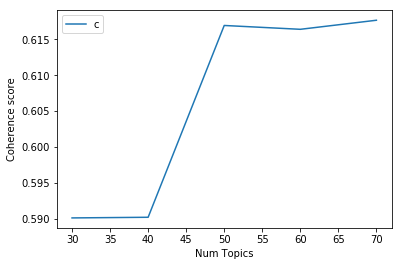

In [91]:
limit=80; start=30; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [183]:
def format_topics_sentences(ldamodel=model_list[len(model_list)-1], 
                            corpus=corpus, 
                            texts=subset['extended_tweet'],
                            score=subset.score):
    # Init output
    df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        # Here we grab a list of topics, and their contributions to the model
        topics = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Here we're grabbing the most dominant topic, the first index of our  row
        # topic_num is the dominant topic number, and topic_prop is the proportion
        # of that topic in the tweet. (Low numbers are OK)
        
        topic_num, topic_prop = topics[0] 
        
        # Gather words important to the topic
        wp = ldamodel.show_topic(topic_num) 
        
        keywords = ", ".join([word for word, prop in wp])
        # Save them to our data frame
        df = df.append(pd.Series([int(topic_num), 
                                  round(topic_prop ,4), 
                                  keywords]), 
                                  ignore_index=True)

    df.columns = ['topic', 'percent', 'keywords']

    # Add original text and sentiment to the data frame 
    contents = pd.Series(texts)
    score = pd.Series(score)
    df = pd.concat([df, contents, score],axis=1)
    
    
    return(df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model_list[3], 
                                                  corpus=corpus, 
                                                  texts=subset['extended_tweet'].values.tolist(),
                                                  score=subset.reset_index().score)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['number', 'topic', 'percent', 'keywords', 'tweet', 'score']

# Show
df_dominant_topic.head(10)

,number,topic,percent,keywords,tweet,score
0,0,11.0,0.0319,"book, food, awesome, person, ready, local, swe...",@GoaleeMurph @kasim_a29 @GalvanisdHockey Glad ...,0.4588
1,1,19.0,0.0450,"month, bad, order, comment, answer, lol, poten...",Sun worship💜💜💜. November is upon us. Not my fa...,-0.3412
2,2,3.0,0.0346,"watching, son, power, score, movie, run, leagu...",@ATPlive I know it’s not a meme but how I feel...,0.0000
3,3,38.0,0.0434,"happy, kid, birthday, phone, girl, cat, cut, t...",This video by Creationist Cat is fucking aweso...,0.7346
4,4,0.0,0.0333,"game, tonight, move, action, calling, remember...",What time is our game today..My LFC Family😎,0.0000
5,5,4.0,0.0463,"canada, canadian, base, listening, hope, park,...","@MMFlint Sorry Michael, but there were four me...",0.9009
6,6,52.0,0.0374,"play, big, playing, early, complete, yesterday...",Yesterday patience asked me “this Sunday is sa...,0.0000
7,7,33.0,0.0757,"morning, friend, week, family, beautiful, amer...",@JILLCLARK1808 @AnfieldMyLife @liverpool19800 ...,0.7430
8,8,33.0,0.0838,"morning, friend, week, family, beautiful, amer...",@Henry14Kay @LeroyEdwards8 @jasperlfc @marcial...,0.7430
9,9,26.0,0.0456,"day, case, ticket, public, forward, live, full...",Bedtime is her favourite time. She uses these ...,0.4588


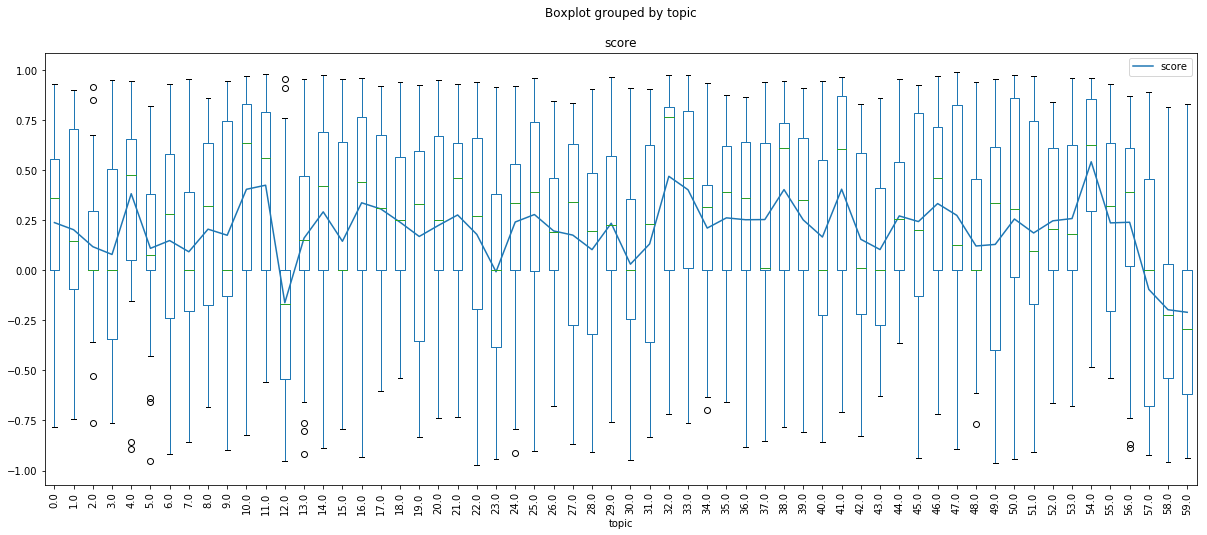

In [290]:
ax = df_dominant_topic.boxplot(figsize = (20,8), column=['score'], by='topic', rot=90)

# Weird off by one error, need to move the mean over. 
def shift(df):
    df.topic +=1
    return df

plot_df = df_dominant_topic.groupby('topic').mean().reset_index().apply(shift, axis=1).copy()

plot_df.plot(kind='line', 
            rot=90,
            y = 'score',
            ax = ax,
            x = 'topic')


In [319]:
print_df = df_dominant_topic[df_dominant_topic.topic == 11].copy()
for index, text in enumerate(print_df.tweet):
    print(text, print_df.percent.iloc[index])
    print(print_df.keywords.iloc[index])
    print()

@GoaleeMurph @kasim_a29 @GalvanisdHockey Glad I specified which keeper then without any reference to dimensionality. 😉 0.0319
book, food, awesome, person, ready, local, sweet, business, bring, blazer

shoutout for @RexLAPro for being the sweetest human being alive thank u 0.0319
book, food, awesome, person, ready, local, sweet, business, bring, blazer

@Razarumi its not the legal profession only its the public at large..there is a serious psychological mess up  possibly because of the the way we r brought up 0.0489
book, food, awesome, person, ready, local, sweet, business, bring, blazer

@SunMountainGolf I like the four way bag!!! 0.0338
book, food, awesome, person, ready, local, sweet, business, bring, blazer

@SeanPullins I read a book almost 20 years ago now describing their play book and looking into why voters consistently vote against their own interest.    Hasn’t changed, only ramped up. 0.0556
book, food, awesome, person, ready, local, sweet, business, bring, blazer

(Psst… we

2528

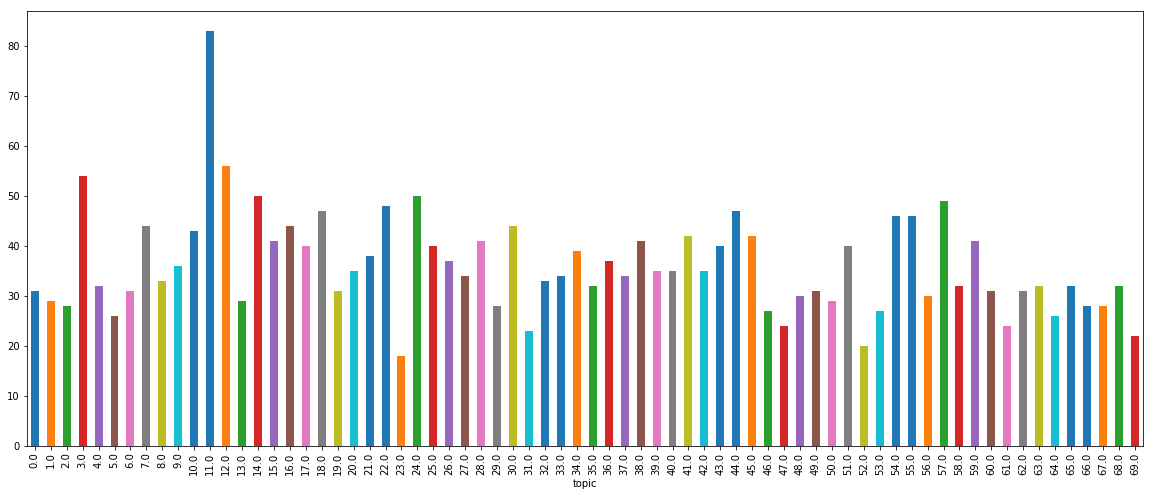

In [146]:
df_dominant_topic.groupby('topic')['score'].count().plot(kind='bar', figsize=(20,8))